In [1]:
import h5py
import glob
import numpy as np 
import matplotlib.pyplot as plt
from scipy import signal
import scipy as sp
from scipy.signal import butter
from scipy.optimize import curve_fit
from lmfit.models import LinearModel, LorentzianModel, GaussianModel, ExponentialModel

In [2]:
# reading h5 file
f = h5py.File("20190518_173944_projection-Copy1.h5")
list(f.keys())
shots = f.get("n-shots")
photE = f.get("x-axis")
intense = f.get("y-axis")
spectrum = range(0,len(intense[:,1]-1))

Filter thresholds & other function inputs

In [306]:
# Low pass filter:
lpcutoff = 0.005
lowpassdata = intense[14,:]
heightcut = 5
dx = 0.1
sidecut = 5

### Defining functions

Low-pass filter

In [307]:
def lowpass(lowpassdata, lpcutoff):
    b, a = signal.butter(5, lpcutoff, 'low')
    spec = signal.filtfilt(b, a, lowpassdata)
    return spec

In [308]:
spec = lowpass(lowpassdata,lpcutoff)
def shift(lowpassdata, lpcutoff):
    return min(spec)
def MaxPeak(lowpassdata, lpcutoff):
    return max(spec)
def dataRawS(lowpassdata, lpcutoff):
    drs = np.array([photE,lowpassdata-shift(lowpassdata,lpcutoff)]).T
    return drs
def Noise(lowpassdata, lpcutoff):
        noise = np.array([photE,lowpassdata-spec]).T
        return noise
def IIData(lowpassdata, lpcutoff):
    return sum(spec-shift(lowpassdata,lpcutoff))
def IINoise(lowpassdata, lpcutoff):
    return sum(lowpassdata-spec)
def IIDataRaw(lowpassdata, lpcutoff):
    return sum(lowpassdata)
def data(lowpassdata,lpcutoff):
    return np.array([photE,spec-shift(lowpassdata,lpcutoff)]).T
    

In [309]:
def plotlowpass(lowpassdata,lpcutoff):
    plt.plot(photE, lowpassdata, label='Raw data')
    plt.plot(photE, lowpass(lowpassdata,lpcutoff), label='filtered')
    plt.plot(photE,data(lowpassdata,lpcutoff)[:,1],label = 'shift adjusted')
    plt.plot(photE,Noise(lowpassdata,lpcutoff)[:,1],label = 'noise')

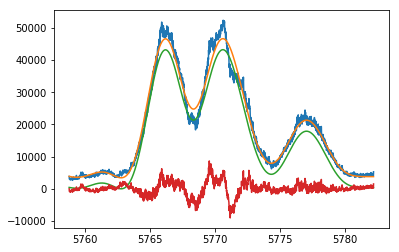

In [310]:
# TEST
plotlowpass(lowpassdata,lpcutoff)

Finding peaks

In [311]:
SD = np.std(lowpassdata-spec)
Data = data(lowpassdata, lpcutoff)
h = (max(Data[:,1]/(100*heightcut)))
peaks = sp.signal.find_peaks(Data[:,1],
                             height=h,
                             distance = SD/10)
pospeaks = np.asarray(np.asarray(peaks)[0])
xpeaks = Data[pospeaks,0]
ypeaks = np.asarray(((str(np.asarray(peaks)[1])).split("array(")[1]).split(")")[0])
Peaks = np.array([[xpeaks],[ypeaks]])

In [312]:
n = len(xpeaks)
if n > 1:
    # checking for close peaks
    for j in range(n):
        if np.sort(abs(xpeaks-xpeaks[j]))[1]<dx:
            peaks = remove(peaks[j])
            pospeaks = peaks[:,0]
            xpeaks = Data[pospeaks,0]
            ypeaks = peaks[:,1]
        #j = j+1
    Peaks = np.array([[xpeaks],[ypeaks]])
    # eliminating peaks close to edge
    for j in range(n):
        if abs(xpeaks[j] - max(photE)) < ((max(photE) - min(photE))*sidecut/100) or abs(xpeaks[j] - min(photE)) < ((max(photE) - min(photE))*sidecut/100):
            peaks = remove(peaks[j])
            pospeaks = peaks[:,0]
            xpeaks = Data[pospeaks,0]
            ypeaks = peaks[:,1]
       # j = j + 1
    Peaks = np.array([[xpeaks],[ypeaks]])
    n = len(xpeaks)

Simple model fit, no conditions

FWHM width of peak 0 :  1.7036623760444842
FWHM width of peak 1 :  2.934411666137634
FWHM width of peak 2 :  3.414298791315494
FWHM width of peak 3 :  3.2761405501304193


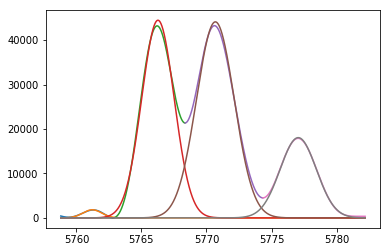

In [313]:
d = Data[:,1]
oldpos = 0
fwhm = []
gaussResults = []
for i in range(n):
    if i != n-1:
        minimumy = min(d[pospeaks[i]:pospeaks[i+1]])
        position = np.asarray(np.where(d == minimumy))
    else:
        pass
    if i == 0:
        slices = np.array(d[:int(position)])
        plt.plot(photE[:int(position)],slices)
    elif i != n-1:
        slices = np.array(d[oldpos:int(position)])
        plt.plot(photE[oldpos:int(position)],slices)
    else:
        slices = np.array(d[int(position):])
        plt.plot(photE[int(position):],slices)   
    
    spfs = []
    j = 0
    while j < len(d):
        if i == n-1:
            if j < int(position):
                spfs = np.append(spfs,0)
            else:
                spfs = np.append(spfs,slices[j-oldpos])
        else:
            if j < int(position) and j >= oldpos:
                spfs = np.append(spfs,slices[j-oldpos])
            else:
                spfs = np.append(spfs,0)
        j = j + 1
    oldpos = int(position)
    
    mod = GaussianModel()
    pars = mod.guess(spfs, x=Data[:,0])
    out = mod.fit(spfs, pars, x=Data[:,0])
    fwhm.append(out.params['fwhm'].value)
    print("FWHM width of peak", i,": ",out.params['fwhm'].value)
    gaussResult = out.best_fit
    if i == 0:
        gaussResults = gaussResult
    else:
        gaussResults = np.vstack((gaussResults,gaussResult))
    #plt.plot(photE,spfs)
    plt.plot(photE,gaussResult)
#plt.plot(photE,d)

In [314]:
# Adding Gaussians
j = 0
GaussAdd = gaussResults[0,:]
while j < len(gaussResults[1]):
    for i in range(1,n):
        GaussAdd[j] = GaussAdd[j] + gaussResults[i,j]
    j = j+1

In [315]:
print(GaussAdd.shape,gaussResults.shape)

(2560,) (4, 2560)


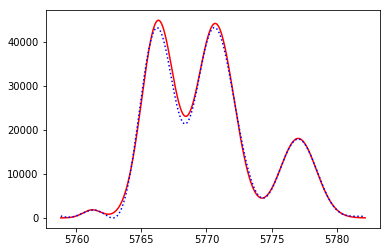

In [316]:
plt.plot(photE,GaussAdd,"r-",label='Gaussian fit')
plt.plot(photE,data(lowpassdata,lpcutoff)[:,1],"b:", label='Lowpass filter')
#for i in range(n):
 #   plt.plot(photE,gaussResults[i,:], label='Indiv. Ga')


In [317]:
GPeaks = sp.signal.find_peaks(GaussAdd,
                             height=1000,
                             prominence = max(GaussAdd)/10)
GPeaks = np.asarray(np.asarray(GPeaks)[0])
print(GPeaks)

[ 821 1298 1996]


In [318]:
Maxes = []
MaxIndices = []
for i in GPeaks:
    Range = int(len(GaussAdd)/20)
    realMax = max((data(lowpassdata,lpcutoff)[:,1])[i-Range:i+Range])
    Maxes = np.append(Maxes,realMax)
    maxIndex = np.where(data(lowpassdata,lpcutoff)[:,1] == realMax)
    maxIndex = photE[int(np.asarray(maxIndex))]
    MaxIndices = np.append(MaxIndices,maxIndex)
    
print(Maxes, MaxIndices)

[43187.29994217 43232.8097754  17899.11770645] [5766.20679953 5770.61430246 5777.04267292]


In [364]:
realMins = []
mIndices = []
Range = int(len(GaussAdd)/20)
if len(Maxes) > 1:
    # Finding overlapping points
    for i in range(len(Maxes)-1):
        index1 = int(np.asarray(np.where((data(lowpassdata,lpcutoff)[:,1]) == Maxes[i])))
        index2 = int(np.asarray(np.where((data(lowpassdata,lpcutoff)[:,1]) == Maxes[i+1])))
        gaussMin = min(GaussAdd[index1:index2])
        mIndex = int(np.asarray(np.where(GaussAdd == gaussMin)))
        #print((data(lowpassdata,lpcutoff)[:,1])[int(mIndex-Range):int(mIndex+Range)])
        #print((data(lowpassdata,lpcutoff)[:,1]))
        realMin = min((data(lowpassdata,lpcutoff)[:,1])[int(mIndex-Range):int(mIndex+Range)])
        realMins = np.append(realMins,realMin)
        mIndex = photE[int(np.asarray(mIndex))]
        mIndices = np.append(mIndices,mIndex)
            

In [365]:
print(len(Maxes.shape))

1


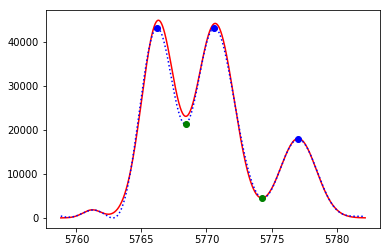

In [366]:
plt.plot(photE,GaussAdd,"r-",label='Gaussian fit')
plt.plot(photE,data(lowpassdata,lpcutoff)[:,1],"b:", label='Lowpass filter')
#for i in range(n):
 #   plt.plot(photE,gaussResults[i,:], label='Indiv. Ga')
for k in range(len(Maxes)):
    plt.plot(MaxIndices[k],Maxes[k],'bo')
for j in range(len(realMins)):
    plt.plot(mIndices[j],realMins[j],'go')

In [321]:
"""def FitFunction(dataset):
    MinPeaksPos = np.array([])
    MinPeaks = []
    MinPeaksPos[0] = 1
    MinPeaksPos[-1] = -1
    for j in range(n-1):
        index1 = pospeaks[j]
        index2 = pospeaks[j+1]
        a = (Data[:,1])[index1:index2]
        MinPeaksPos[j+1] = np.where(a = min(a)[0,0]+pospeaks[j])
        j = j + 1
    MinPeaks = dataset[MinPeaksPos]
    
    
    for j in range(n):
        index1 = MinPeaksPos[j]
        index2 = MinPeaksPos[j+1]
        datapiece = Data[index1:index2]
        A = 1
        mu = 1
        sigma = 1
        x = dataset[:,j]
        resfunc[j]=peakfunc(A, mu, sigma, x)
    photE = Data[:,0]
    return resfunc"""

'def FitFunction(dataset):\n    MinPeaksPos = np.array([])\n    MinPeaks = []\n    MinPeaksPos[0] = 1\n    MinPeaksPos[-1] = -1\n    for j in range(n-1):\n        index1 = pospeaks[j]\n        index2 = pospeaks[j+1]\n        a = (Data[:,1])[index1:index2]\n        MinPeaksPos[j+1] = np.where(a = min(a)[0,0]+pospeaks[j])\n        j = j + 1\n    MinPeaks = dataset[MinPeaksPos]\n    \n    \n    for j in range(n):\n        index1 = MinPeaksPos[j]\n        index2 = MinPeaksPos[j+1]\n        datapiece = Data[index1:index2]\n        A = 1\n        mu = 1\n        sigma = 1\n        x = dataset[:,j]\n        resfunc[j]=peakfunc(A, mu, sigma, x)\n    photE = Data[:,0]\n    return resfunc'

In [15]:
"""MinPeaksPos = np.array([0,n+1])
MinPeaks = np.array([0,n+1])
index1 = MinPeaksPos[0]
index2 = MinPeaksPos[1]
datapiece = Data[index1:index2]"""

'MinPeaksPos = np.array([0,n+1])\nMinPeaks = np.array([0,n+1])\nindex1 = MinPeaksPos[0]\nindex2 = MinPeaksPos[1]\ndatapiece = Data[index1:index2]'

In [16]:
"""def lowpass(lowpassdata, lpcutoff):
    # Butterworth low pass filter
    plt.plot(photE, lowpassdata, label='Raw data')
    b, a = signal.butter(5, lpcutoff, 'low')
    spec = signal.filtfilt(b, a, lowpassdata)
    plt.plot(photE, spec, label='filtered')
    
    # Other definitions probably useful within function
    shift = min(spec)
    MaxPeak = max(spec)
    dataRawS = np.array([photE,lowpassdata-shift]).T
    Noise = np.array([photE,lowpassdata-spec]).T
    IIData = sum(spec-shift)
    IINoise = sum(lowpassdata-spec)
    IIDataRaw = sum(lowpassdata)
    
    # Collected data set, shift adjusted
    data = np.array([photE,spec-shift]).T
    
    plt.plot(photE,data[:,1],label = 'shift adjusted')
    plt.plot(photE,Noise[:,1],label = 'noise')
    
    plt.legend()
    plt.show()    
    print("With frequency cut-off: ",lpcutoff)
    return spec, photE"""

'def lowpass(lowpassdata, lpcutoff):\n    # Butterworth low pass filter\n    plt.plot(photE, lowpassdata, label=\'Raw data\')\n    b, a = signal.butter(5, lpcutoff, \'low\')\n    spec = signal.filtfilt(b, a, lowpassdata)\n    plt.plot(photE, spec, label=\'filtered\')\n    \n    # Other definitions probably useful within function\n    shift = min(spec)\n    MaxPeak = max(spec)\n    dataRawS = np.array([photE,lowpassdata-shift]).T\n    Noise = np.array([photE,lowpassdata-spec]).T\n    IIData = sum(spec-shift)\n    IINoise = sum(lowpassdata-spec)\n    IIDataRaw = sum(lowpassdata)\n    \n    # Collected data set, shift adjusted\n    data = np.array([photE,spec-shift]).T\n    \n    plt.plot(photE,data[:,1],label = \'shift adjusted\')\n    plt.plot(photE,Noise[:,1],label = \'noise\')\n    \n    plt.legend()\n    plt.show()    \n    print("With frequency cut-off: ",lpcutoff)\n    return spec, photE'

In [ ]:
"""
    Search for x-indices where y-value is similar between two Gaussians.
    Must loop over all adjacent
    Must eliminate the cases where y is zero
    If in a given range (increments of Range or half), two Gaussians come closer
    than certain threshold, (robustly search for exact point) - 
    for fast processing go directly to raw data
    
    NOPE, search for added Gaussian minima.
    
    for i in range(len(gaussResults[0])-1):
        gauss1 = gaussResults[i,:]
        gauss2 = gaussResults[i+1,:]
        for k in range(0,len(gauss1)-1, int(Range/2)):
            print("starting", k)
            if k > MaxIndices[i]:
                if gauss1[k] < 10:
                    pass
                elif gauss2[k] < 10:
                    pass
                else:
                    if abs(gausssubt[k]) < 10:
                        print("stuck in loop")
                        #print(data(lowpassdata,lpcutoff)[:,1])
                        overlap = min((np.asarray(data(lowpassdata,lpcutoff)[:,1])[k-Range:k+Range]))
                        overlaps = np.append(overlaps,overlap)
                        overlapI = np.append(overlapI,np.where(data(lowpassdata,lpcutoff)[:,1] == overlap))
                        
            """

In [17]:
"""class mod1:
    def __init__(self, lowpassdata,lpcutoff):
        self.lowpassdata = lowpassdata
        self.lpcutoff = lpcutoff
    
    def lowpass(self):
        b, a = signal.butter(5, self.lpcutoff, 'low')
        spec = signal.filtfilt(b, a, self.lowpassdata)
        return spec
    
    def getshift(lowpass):
        shift = min(lowpass(self))
    
    def get"""

"class mod1:\n    def __init__(self, lowpassdata,lpcutoff):\n        self.lowpassdata = lowpassdata\n        self.lpcutoff = lpcutoff\n    \n    def lowpass(self):\n        b, a = signal.butter(5, self.lpcutoff, 'low')\n        spec = signal.filtfilt(b, a, self.lowpassdata)\n        return spec\n    \n    def getshift(lowpass):\n        shift = min(lowpass(self))\n    \n    def get"

In [18]:
# need to feed a, mu, sigma to function. Maybe integrate with peakfunc
def modelFM(data, n, g):
    dataconfig = A, mu, sigma # would create map, but n = 1 as defined later
    def Guess(muG):
        g = muG
    dataconfigG =
    modelfunc = peakfunc(data)
    objfunc = sum(Data[:,1]-modelfunc)
    bbM = 

SyntaxError: invalid syntax (<ipython-input-18-32d94dc8bb14>, line 6)